In [1]:
import torch
from torch.utils import data
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
from skimage import io, transform

## Turning on cuda gpu

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available

## Getting data

#### Defining dataloader params and normalizing values

In [64]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}

data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

#### Defining custom tranform for target

In [4]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [5]:
!unzip "/content/drive/My Drive/Colab Notebooks/data_semantics.zip"
!unzip "/content/drive/My Drive/Colab Notebooks/devkit_semantics.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/ima

In [65]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [66]:
import os
import collections
import pdb

class KittiDataset(Dataset): # Pytorch dataset class
# important functions len and getitem
# Load data in an efficient way, like multiple CPUs
# To speed up process in training specially for HD images so it can have multithreading features
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images = os.listdir(os.path.join(root_dir, 'image_2'))
        self.labels = os.listdir(os.path.join(root_dir, 'semantic'))

        # self.files = glob(os.path.join(root_dir))

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()

      img_path = os.path.join(self.root_dir + '/image_2', self.images[idx])
      label_path = os.path.join(self.root_dir + '/semantic', self.images[idx])
      # since the name of the image is the first attribute of the header file we call 0 row
      # image = io.imread(img_path)
      image = pil_loader(img_path)
      label = Image.open(label_path)
      # label = pil_loader(label_path)
      # label = io.imread(label_path)

      sample = {'image': image, 'label': label}

      if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['label'] = self.target_transform(sample['label'])
            
      return sample

#### Loading data using dataloaders

In [8]:
class ConvertToBackground(object):
  def __call__(self, img):
    img = np.asarray(img, dtype=np.long)
    img[img == 255] = 0
    img = torch.from_numpy(img)
    return img

In [9]:
from torch.utils.data import random_split
root_dir = '/content/training'

data_set = KittiDataset(root_dir=root_dir)

In [10]:
# # Change visualization with Kitti visualization kit
# fig = plt.figure()

# for i in range(len(data_set)):

#     image, label = data_set[i]['image'], data_set[i]['label']

#     # print(i, sample['image'].shape, sample['label'].shape)

#     ax = plt.subplot(1, 4, i + 1)

#     # plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')

#     # plt.show(image)
#     # plt.show(label)
#     plt.gcf().set_size_inches(15, 12)

#     if i == 3:
#         plt.show()
#         break

In [67]:
input_size = (224, 224)
# input_size = (292, 585)

short_size = int(min(input_size) / 0.875)

img_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(input_size),
    # transforms.Resize(short_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

target_transform = transforms.Compose([
    # transforms.ToPILImage(),

    transforms.Resize(input_size),
    ConvertToBackground()
])

transformed_dataset = KittiDataset(root_dir=root_dir, 
                                   transform=img_transform, target_transform=target_transform)

val_size = 30
test_size = 30
train_size = len(transformed_dataset) - val_size

train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

train_loader = data.DataLoader(train_set, **params)

val_loader = data.DataLoader(val_set, **params)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(str(i) + " " + str(sample['image'].shape) + " " + str(sample['label'].shape))

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([224, 224])
1 torch.Size([3, 224, 224]) torch.Size([224, 224])
2 torch.Size([3, 224, 224]) torch.Size([224, 224])
3 torch.Size([3, 224, 224]) torch.Size([224, 224])


## Downloading pretrained vgg16 model

In [12]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


#### Freezing convolution layers

In [13]:
for param in vgg16.features.parameters():
  param.requires_grad = False

## Defining FCN32 network

In [69]:
num_classes = 35

class FCN32(nn.Module):
  def __init__(self):
    super(FCN32, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, num_classes, 1),
      nn.ConvTranspose2d(num_classes, num_classes, 224, stride=32)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

fcn = FCN32()
fcn.to(device)

# num_classes = 35

# class FCN32(nn.Module):
#   def __init__(self):
#     super(FCN32, self).__init__()
#     self.features = vgg16.features
#     self.classifier = nn.Sequential(
#       nn.Conv2d(512, 4096, 7),
#       nn.ReLU(inplace=True),
#       nn.Dropout2d(),
#       nn.Conv2d(4096, 4096, 1),
#       nn.ReLU(inplace=True),
#       nn.Dropout2d(),
#       nn.Conv2d(4096, num_classes, 1),
#       # nn.ConvTranspose2d(num_classes, num_classes, kernel_size=(28,28), stride=28, padding=0, bias=False)
#       nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)
#     )

#   def forward(self, x):
#     x = self.features(x)
#     x = self.classifier(x)
#     return x

# fcn = FCN32()
# fcn.to(device)

FCN32(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [15]:
# num_classes = 35

# class FCN32(nn.Module):
#     def __init__(self, num_classes, pretrained=True):
#         super(FCN32VGG, self).__init__()
#         vgg = models.vgg16()
#         if pretrained:
#             vgg.load_state_dict(torch.load(vgg16_caffe_path))
#         features, classifier = list(vgg.features.children()), list(vgg.classifier.children())

#         features[0].padding = (100, 100)

#         for f in features:
#             if 'MaxPool' in f.__class__.__name__:
#                 f.ceil_mode = True
#             elif 'ReLU' in f.__class__.__name__:
#                 f.inplace = True

#         self.features5 = nn.Sequential(*features)

#         fc6 = nn.Conv2d(512, 4096, kernel_size=7)
#         fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
#         fc6.bias.data.copy_(classifier[0].bias.data)
#         fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
#         fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
#         fc7.bias.data.copy_(classifier[3].bias.data)
#         score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
#         score_fr.weight.data.zero_()
#         score_fr.bias.data.zero_()
#         self.score_fr = nn.Sequential(
#             fc6, nn.ReLU(inplace=True), nn.Dropout(), fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr
#         )

#         self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)
#         self.upscore.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 64))

#     def forward(self, x):
#         x_size = x.size()
#         pool5 = self.features5(x)
#         score_fr = self.score_fr(pool5)
#         upscore = self.upscore(score_fr)
#         return upscore[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])].contiguous()

#### Checks to see proper weight updation and correct transfer

In [16]:
# print('FEATURE parameters requires gradients: {}'.format(any([param.requires_grad for param in fcn.features.parameters()])))
# print('CLASSIFIER parameters requires gradients: {}'.format(all([param.requires_grad for param in fcn.classifier.parameters()])))
# print('Transferred FEATURE parameters from VGG16 to FCN: {}'.format(list(fcn.features.parameters()) == list(vgg16.features.parameters())))
# print('Number of params transfered: {}'.format(sum(p.numel() for p in fcn.features.parameters())))
# print('Number of params left in network to be updated: {}'.format(sum(p.numel() for p in fcn.classifier.parameters())))

## Defining FCN16 network

In [70]:
num_classes = 35

class FCN16(nn.Module):
  def __init__(self):
    super(FCN16, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, num_classes, 1)
    )
    self.score_pool4 = nn.Conv2d(512, num_classes, 1)
    self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 14, stride=2, bias=False)
    self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, 16, stride=16, bias=False)

  def forward(self, x):
    pool4 = self.features[:-7](x)
    pool5 = self.features[-7:](pool4)
    pool5_upscored = self.upscore2(self.classifier(pool5))
    pool4_scored = self.score_pool4(pool4)
    combined = pool4_scored + pool5_upscored
    res = self.upscore16(combined)
    return res

fcn = FCN16()
fcn.to(device)

FCN16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

## Defining criterion and optimizer

In [77]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fcn.parameters(), lr=0.001, momentum=0.99)


# criterion = nn.CrossEntropyLoss()
# betas = (0.5, 0.999)

# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001, betas=betas)

## Defining function that calculates iou and dice score

In [78]:
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou

## Backprop

In [84]:
best_loss = 1000000000
num_epochs = 100
j = 0
for epoch in range(num_epochs):
  val_running_loss = 0
  iou_running_score = 0
  dice_running_score = 0
  fcn.train()
  for i, dat in enumerate(train_loader):

    j += 1
    # Get image, label pair
    inputs, labels = dat['image'], dat['label']

    print(i)

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Set parameter gradients to 0
    optimizer.zero_grad()

    # Forward pass for a batch
    outputs = fcn(inputs)

    # pdb.set_trace()

    # Compute loss
    loss = criterion(outputs, labels)

    # Backpropagate
    loss.backward()

    # Update the weights
    optimizer.step()

    # print training loss
    print('[{}, {}] training loss:{}'.format(epoch+1, i+1, loss.item()))
    # tb.save_value('Train Loss', 'train_loss', j, loss.item())

  fcn.eval()
  with torch.no_grad():
    for k, dat1 in enumerate(val_loader):
      # Get image, label pair
      inputs1, labels1 = dat1['image'], dat1['label']

      # # Using GPU
      inputs1 = inputs1.to(device)
      labels1 = labels1.to(device)

      # Predicting segmentation for val inputs
      outputs1 = fcn(inputs1)

      # Compute CE loss and aggregate it
      loss1 = criterion(outputs1, labels1)
      val_running_loss += loss1

      # Reshaping prediction segmentations and actual segmentations for iou and dice score
      preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
      gt = labels1.detach().cpu().numpy()

      # Compute confusion matrix
      conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(21)))

      # Computing iou and dice scores and aggregating them
      iou_score = get_mean_iou(conf_mat=conf_mat)
      iou_running_score += iou_score
      dice_score = get_mean_iou(conf_mat=conf_mat, multiplier=2.0)
      dice_running_score += dice_score

    # Averaging loss and scores
    avg_val_loss = float(val_running_loss)/(k+1)
    avg_iou_score = float(iou_running_score)/(k+1)
    avg_dice_score = float(dice_running_score)/(k+1)

    if avg_val_loss < best_loss:
      best_loss = avg_val_loss
      torch.save(fcn.state_dict(), '/content/best_model_fcn16.pth.tar')

    # Visualizations for batch wise metrics
    print('epoch {}, validation loss: {}, iou score: {}, dice score: {}'.format(epoch+1, avg_val_loss, avg_iou_score, avg_dice_score))
    # tb.save_value('Validation Loss', 'val_loss', epoch+1, avg_val_loss)
    # tb.save_value('IOU', 'iou', epoch+1, avg_iou_score)
    # tb.save_value('Dice Score', 'dice_score', epoch+1, avg_dice_score)

print('Finished Training')

0
[1, 1] training loss:0.8712770938873291
1
[1, 2] training loss:0.7158116698265076
2
[1, 3] training loss:0.836128830909729
3
[1, 4] training loss:0.4192081689834595
4
[1, 5] training loss:1.0971378087997437
5
[1, 6] training loss:1.165449619293213
6
[1, 7] training loss:0.8138967156410217
7
[1, 8] training loss:1.3640385866165161
8
[1, 9] training loss:0.6908167004585266
9
[1, 10] training loss:0.757274866104126
10
[1, 11] training loss:0.7710800170898438
11
[1, 12] training loss:0.8780445456504822
12
[1, 13] training loss:0.8446975946426392
13
[1, 14] training loss:0.9567527770996094
14
[1, 15] training loss:0.504524827003479
15
[1, 16] training loss:0.4432348608970642
16
[1, 17] training loss:0.7967032790184021
17
[1, 18] training loss:0.9810172915458679
18
[1, 19] training loss:0.8240251541137695
19
[1, 20] training loss:1.2761458158493042
20
[1, 21] training loss:0.728460967540741
21
[1, 22] training loss:1.0935264825820923
22
[1, 23] training loss:1.0172992944717407
23
[1, 24] t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Streaming output truncated to the last 5000 lines.
[86, 59] training loss:0.7404995560646057
59
[86, 60] training loss:0.3192580044269562
60
[86, 61] training loss:0.7239758372306824
61
[86, 62] training loss:0.7747563719749451
62
[86, 63] training loss:0.4457160532474518
63
[86, 64] training loss:0.8013443350791931
64
[86, 65] training loss:0.8975082039833069
65
[86, 66] training loss:0.7066011428833008
66
[86, 67] training loss:0.7744236588478088
67
[86, 68] training loss:0.7176569700241089
68
[86, 69] training loss:0.5893312692642212
69
[86, 70] training loss:0.6927589178085327
70
[86, 71] training loss:0.4499646723270416
71
[86, 72] training loss:0.3499375283718109
72
[86, 73] training loss:0.27952656149864197
73
[86, 74] training loss:0.4451671540737152
74
[86, 75] training loss:0.7458895444869995
75
[86, 76] training loss:0.7265342473983765
76
[86, 77] training loss:0.6199579238891602
77
[86, 78] training loss:0.36596086621284485
78
[86, 79] training loss:0.45673608779907227
79
[

## Examining performance on entire validation set

#### Loading best saved model

In [42]:
model = FCN32()
model.load_state_dict(torch.load('/content/best_model_fcn16.pth.tar'))
model.to(device)
model.eval()

FCN32(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [43]:
# model = FCN16()
# model.load_state_dict(torch.load('/content/best_model_fcn16.pth.tar'))
# model.to(device)
# model.eval()

#### Calculating DICE score and Mean IOU on entire validation set

In [85]:
overall_conf_mat = np.zeros((35, 35))
with torch.no_grad():
  for k, dat1 in enumerate(val_loader):
    # Get image, label pair
    inputs1, labels1 = dat['image'], dat['label']

    # Using GPU
    inputs1 = inputs1.to(device)
    labels1 = labels1.to(device)

    # Predicting segmentation for val inputs
    outputs1 = model(inputs1)

    preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
    gt = labels1.detach().cpu().numpy()

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(35)))
    overall_conf_mat += conf_mat

print('DICE score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat ,multiplier=2.0), 2)))
print('Mean IOU score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat), 2)))

DICE score: 0.61
Mean IOU score: 0.48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Visualizing results

In [95]:
def decode_segmap(image, nc=35):

  label_colors = np.array([(0, 0, 0),
              (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (111, 74,  0),
              ( 81,  0, 81), (128, 64,128), (244, 35,232), (250,170,160), (230,150,140),
              ( 70, 70, 70), (102,102,156), (190,153,153), (180,165,180), (150,100,100),
              (150,120, 90), (153,153,153), (153,153,153), (250,170, 30), (220,220,0),
              (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60), (255,  0,  0),
              (  0,  0,142), (  0,  0, 70), (  0, 60,100), (  0,  0, 90), (  0,  0,110),
              (  0, 80,100), (  0,  0,230), (119, 11, 32), (  0,  0,142)])

  # label_colors = np.array([(0, 0, 0),
  #              (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
  #              (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
  #              (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
  #              (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [96]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}

val_gen = data.DataLoader(val_set, **params)

In [98]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

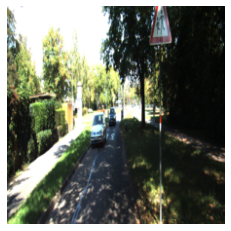

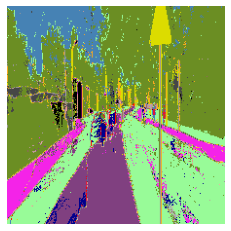

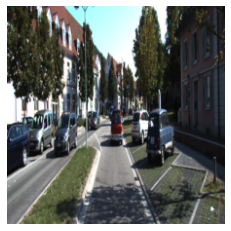

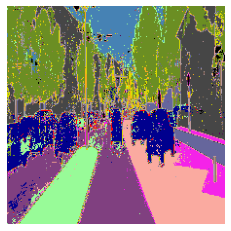

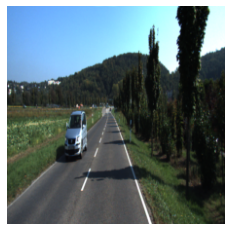

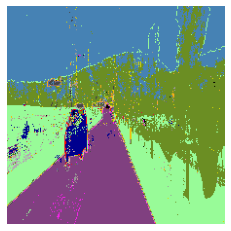

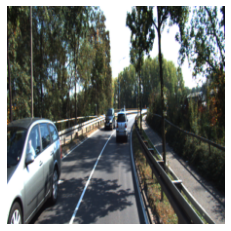

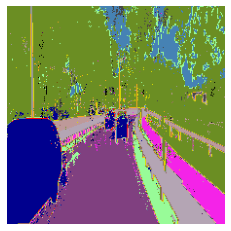

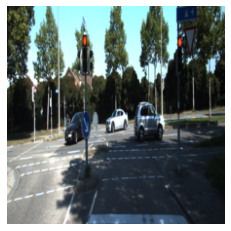

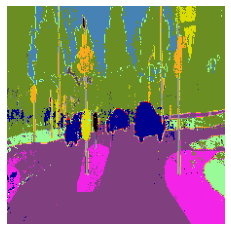

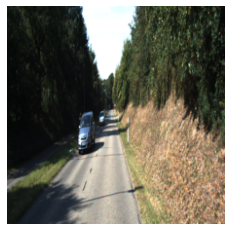

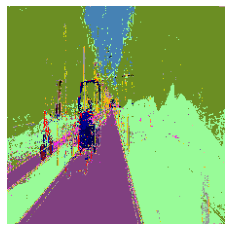

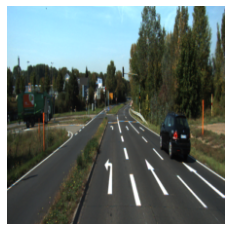

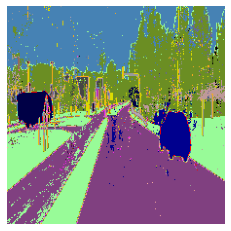

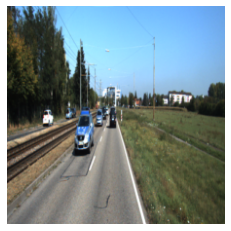

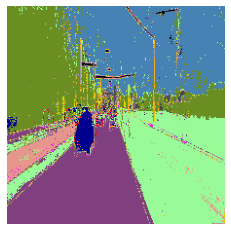

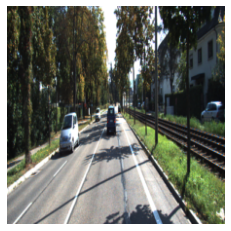

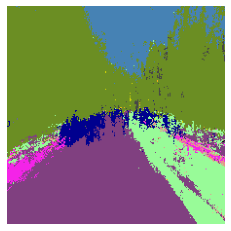

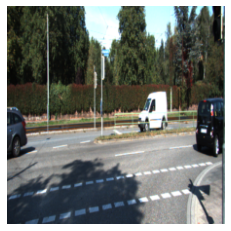

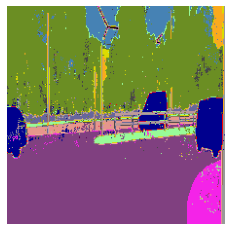

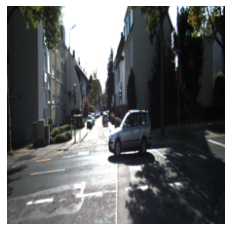

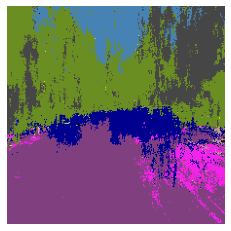

In [138]:
with torch.no_grad():
  for k, dat in enumerate(val_gen):
    # Get image, label pair
    inputs, labels = dat['image'], dat['label']

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    pred = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    
    # Getting the segmentation
    segmentation = decode_segmap(pred)

    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    unnormalized_image = unorm(inputs[0].cpu())
    image_array = np.transpose(unnormalized_image.numpy(), (1, 2, 0))

    plt.imshow(image_array); plt.axis('off');
    plt.show()

    plt.imshow(segmentation);  plt.axis('off');
    plt.show()

    if k == 10:
        break

## Steps to figure out
- Visualize results using colormap thing in PDF
- Use hook functions to code FCN-16